In [403]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import stats
#scikit-learn related imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim
import openpyxl

# imports from captum library
from captum.attr import IntegratedGradients,  GradientShap,FeatureAblation
from sklearn.utils import resample
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()
from torch.utils.data import DataLoader

In [404]:
BD_synthetic = pd.read_csv('../data/BD_synthetic.csv')
HC_synthetic = pd.read_csv('../data/HC_synthetic.csv')

In [405]:
X = HC_synthetic.drop(columns=['Age at Visit']).values
y = HC_synthetic['Age at Visit'].values

In [406]:
pattern = 'FLAIR|Corpus Callosum|hippocampal plus parahippocampal'
contains_columns = HC_synthetic.columns.str.contains(pattern)
HC_synthetic = HC_synthetic.iloc[:,contains_columns]

In [407]:
normalized_X = X- np.min(X)/np.max(X) - np.min(X)

In [408]:
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.3, random_state=0)
#t_stat, p_val = stats.ttest_ind(X_test, y_test, equal_var=False)  
#print(t_stat, p_val)

In [409]:
torch.manual_seed(1234)
np.random.seed(1234)

In [410]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)




In [411]:
batch_size = 50
num_epochs = 100
learning_rate = 0.0001
size_hidden1 = 100
size_hidden2 = 50
size_hidden3 = 10
size_hidden4 = 1

In [412]:
class BrainAgeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(8, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

In [413]:
model = CaliforniaModel()
model.train()

CaliforniaModel(
  (lin1): Linear(in_features=8, out_features=100, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=10, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

In [414]:
criterion = nn.MSELoss(reduction='sum')


In [415]:
def train(model_inp, num_epochs = num_epochs):
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

In [416]:
criterion = nn.MSELoss(reduction='sum')

In [417]:
def train_load_save_model(model_obj, model_path):
    if path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:    
        # train model
        train(model_obj)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)

In [418]:
model.eval()
outputs = model(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (36x88 and 8x100)

In [ ]:
def mean_absolute_error(output, y_test):
    mae = torch.mean(torch.abs(output - y_test))
    return mae

In [ ]:
mean_absolute_error(outputs, y_test)

tensor(3628.0906, grad_fn=<MeanBackward0>)

In [ ]:
mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy())

13200119.0

In [ ]:
gs = GradientShap(model)
fa = FeatureAblation(model)



gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

In [ ]:
features = HC_synthetic.iloc[:, 1:].columns

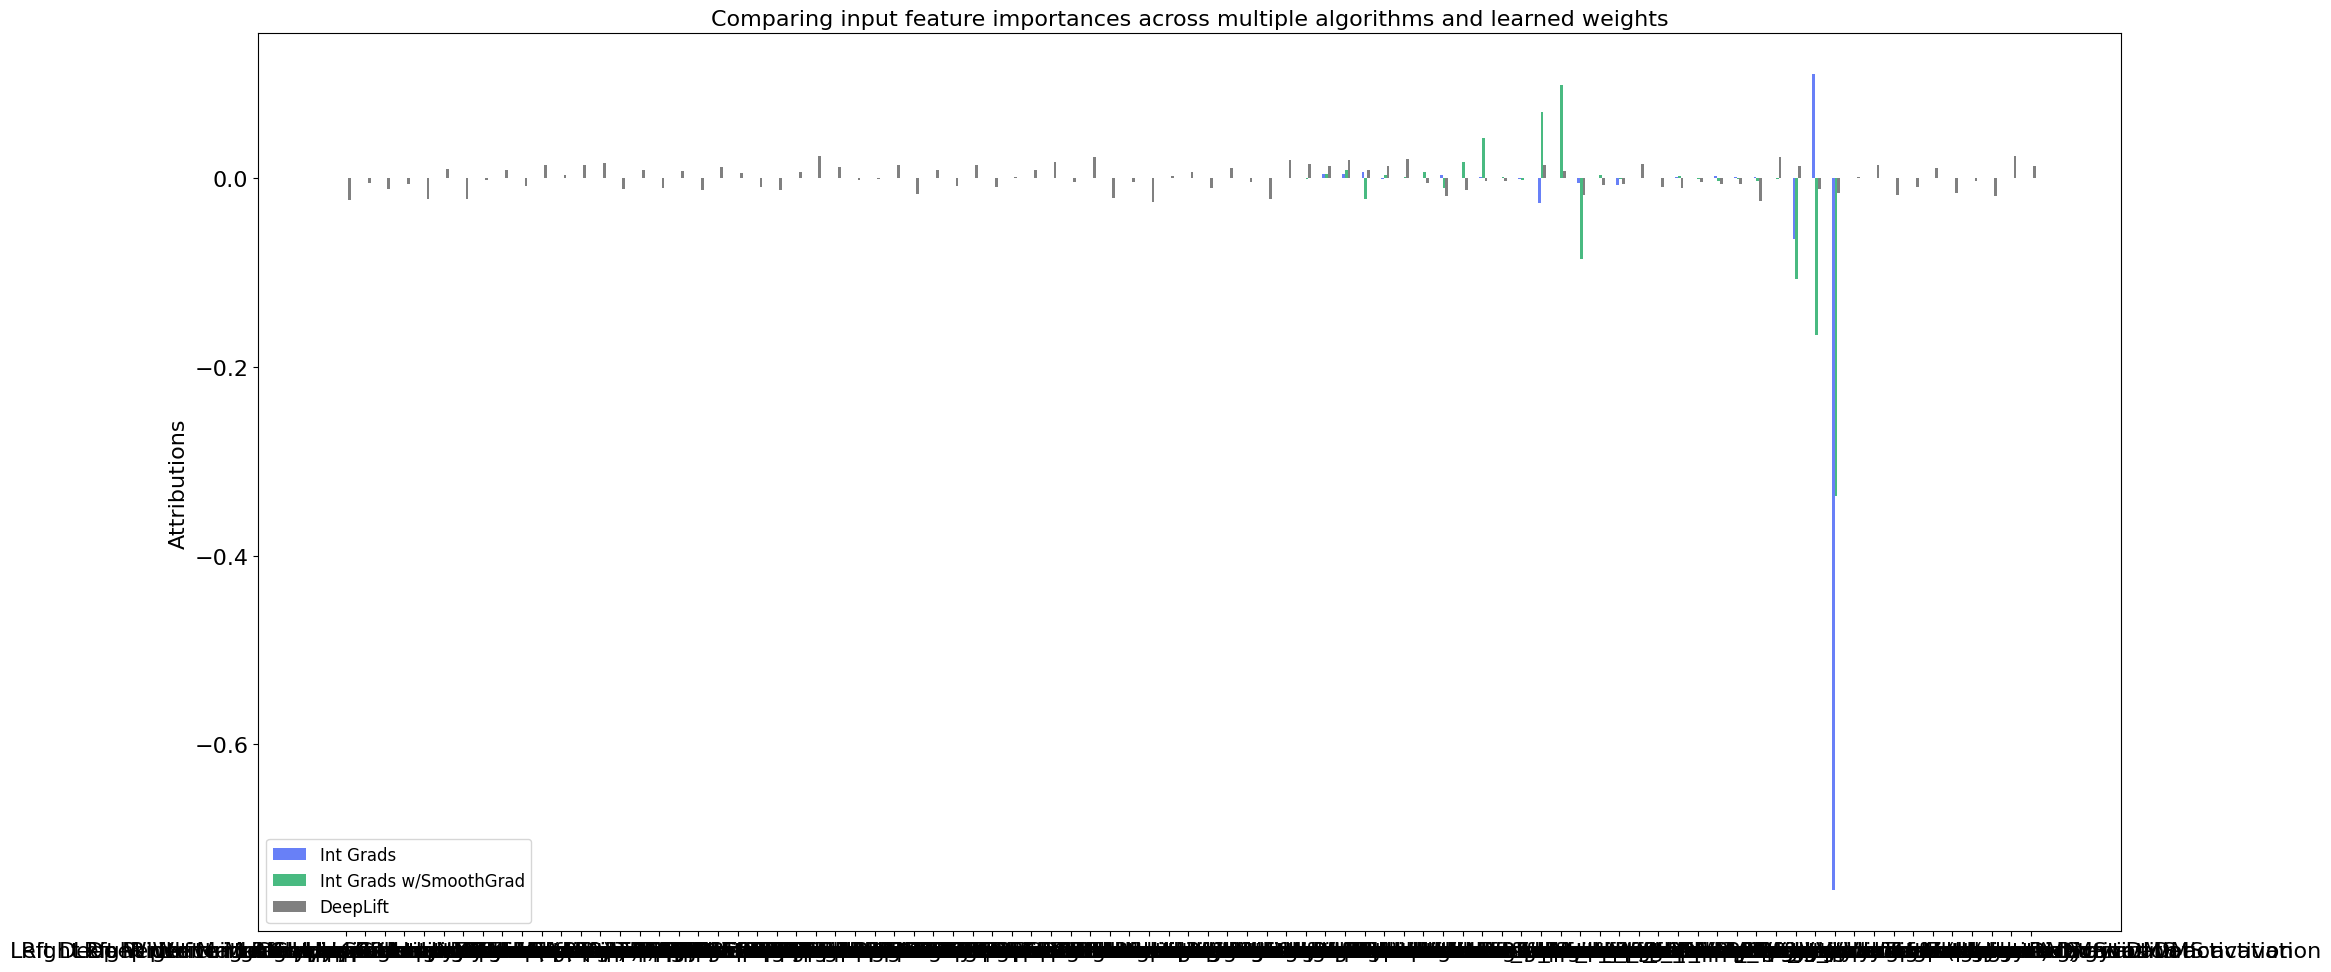

In [ ]:
# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: features[idx], x_axis_data))


gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()